In [50]:
import pandas as pd
import numpy as np

In [51]:
df = pd.read_csv('monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq = 'MS'

In [52]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<AxesSubplot:xlabel='Date'>

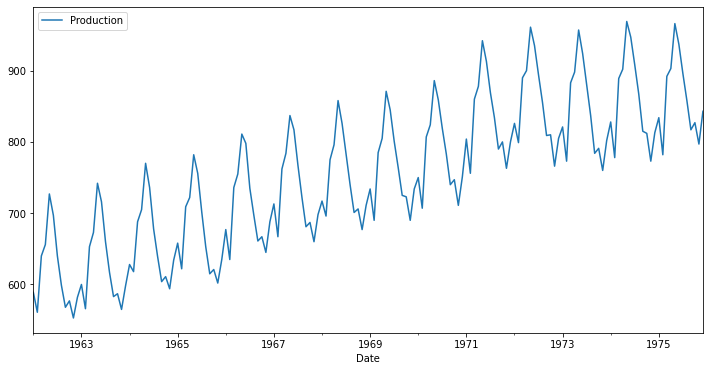

In [53]:
df.plot(figsize=(12,6))

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

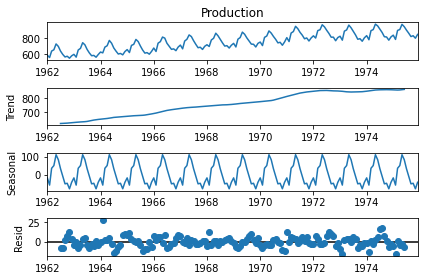

In [55]:
results = seasonal_decompose(df['Production'])
results.plot();

RNN does not require stationary data they can perform on non stationary data as well

In [56]:
len(df)

168

In [57]:
train = df.iloc[:156]
test = df.iloc[156:]

In [58]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [59]:
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [60]:
scaled_train[:10]


array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [61]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [62]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)


generator is generating batches of 3-3 inputs

Example:
    
    input = [1 2 3] , output = [4]

    input1 = [2 3 4],output = [5]

    input2 = [3 4 5],output = [6]
    .
    .
    .
    .
    .

    so on

In [63]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [64]:
X.shape

(1, 3, 1)

In [65]:
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)


In [66]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [67]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [68]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 2s 5ms/step - loss: 0.0544
Epoch 2/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0247
Epoch 3/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0221
Epoch 4/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0217
Epoch 5/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0155
Epoch 6/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0132
Epoch 7/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0079
Epoch 8/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0076
Epoch 9/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0067
Epoch 10/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0056
Epoch 11/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0053
Epoch 12/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0038
Epoch 13/50
144/144 [====

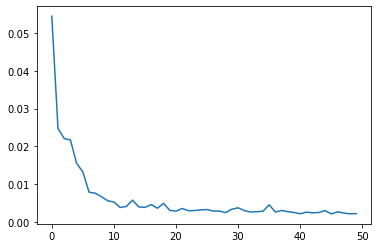

In [70]:
import matplotlib.pyplot as plt
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [71]:
last_train_batch = scaled_train[-12:]
#Here we are taking last 12 values of training set and we gonna make prediction for 1st value of test set

In [72]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))


In [73]:
model.predict(last_train_batch)

array([[0.64200526]], dtype=float32)

In [74]:
scaled_test[0]

array([0.67548077])

In [75]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


In [76]:
test_predictions

[array([0.64200526], dtype=float32),
 array([0.63728833], dtype=float32),
 array([0.7981088], dtype=float32),
 array([0.87448615], dtype=float32),
 array([0.9677165], dtype=float32),
 array([0.95579284], dtype=float32),
 array([0.88748085], dtype=float32),
 array([0.7817347], dtype=float32),
 array([0.6761304], dtype=float32),
 array([0.6353405], dtype=float32),
 array([0.59170634], dtype=float32),
 array([0.6264706], dtype=float32)]

In [77]:
true_predictions = scaler.inverse_transform(test_predictions)

In [78]:
test['Predictions'] = true_predictions

C:\Users\vostr\AppData\Local\Temp/ipykernel_18280/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='Date'>

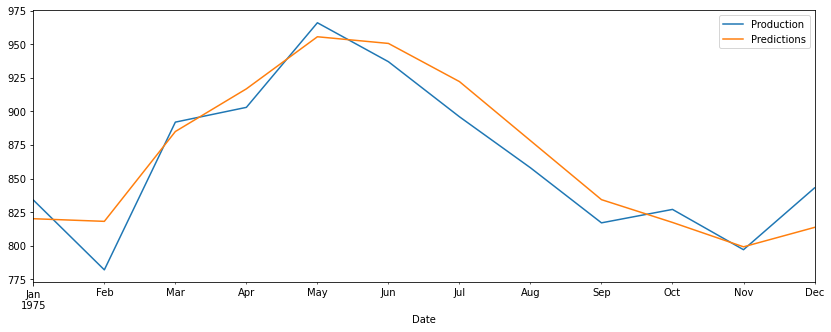

In [79]:
test.plot(figsize=(14,5))

In [80]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

19.117234857060026
